In [1]:
!pip install pytesseract
!apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [13]:
import cv2
import imutils
import numpy as np
import pytesseract
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow  # Importar cv2_imshow para Colab

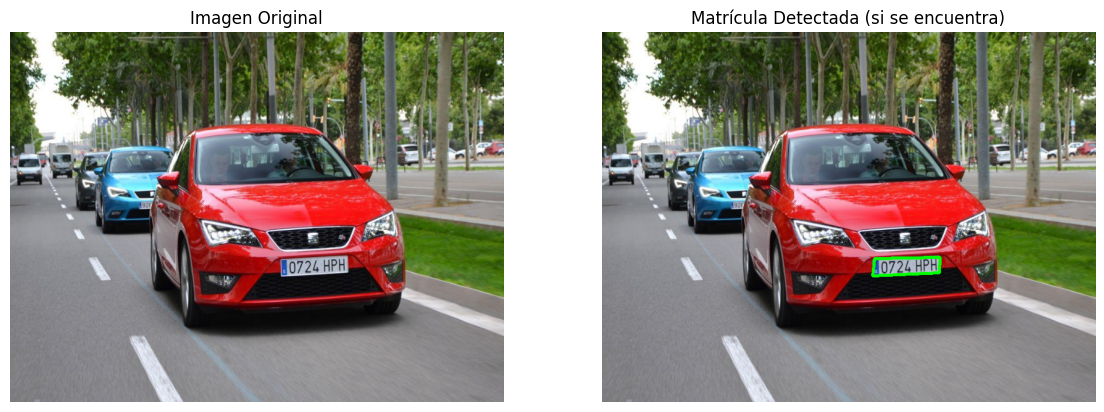

In [23]:
# Cargar y redimensionar la imagen
img = cv2.imread('/content/matricula.jpg', cv2.IMREAD_COLOR)

# Redimensionar la imagen para facilitar el procesamiento
img = cv2.resize(img, (800, 600))

# Convertir a escala de grises y aplicar filtro bilateral (reduce ruido)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.bilateralFilter(gray, 11, 17, 17)

# Detectar bordes con Canny (umbrales ajustados)
edged = cv2.Canny(gray, 30, 200)

# Encontrar contornos
contours, _ = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

# Intentar encontrar un contorno de 4 lados (posible matrícula)
screenCnt = None
for c in contours:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    if len(approx) == 4:
        screenCnt = approx
        break

# Dibujar el contorno si se encuentra
img_with_contours = img.copy()
if screenCnt is not None:
    cv2.drawContours(img_with_contours, [screenCnt], -1, (0, 255, 0), 3)

# Mostrar la imagen original y con contornos detectados
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0].set_title("Imagen Original")
axs[0].axis("off")

axs[1].imshow(cv2.cvtColor(img_with_contours, cv2.COLOR_BGR2RGB))
axs[1].set_title("Matrícula Detectada (si se encuentra)")
axs[1].axis("off")

plt.show()

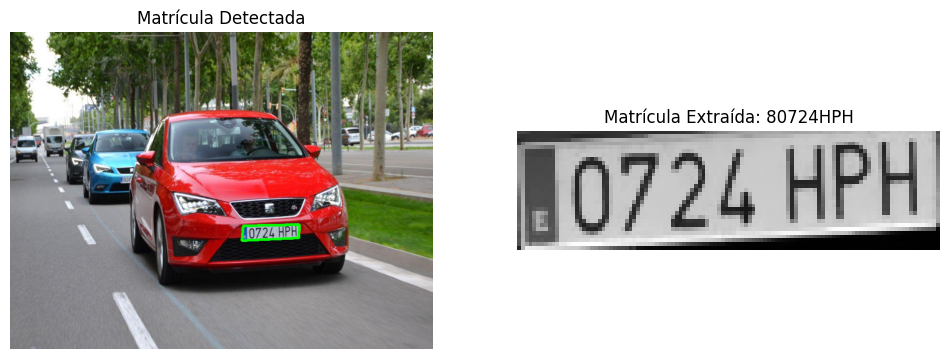

'80724HPH'

In [27]:
# Verificar si se encontró el contorno de la matrícula
if screenCnt is not None:
    # Crear una máscara para aislar la matrícula
    mask = np.zeros(gray.shape, np.uint8)
    cv2.drawContours(mask, [screenCnt], 0, 255, -1)

    # Extraer la región de interés (ROI) de la matrícula
    (x, y) = np.where(mask == 255)
    (topx, topy) = (np.min(x), np.min(y))
    (bottomx, bottomy) = (np.max(x), np.max(y))
    cropped_plate = gray[topx:bottomx + 1, topy:bottomy + 1]

    # Aplicar OCR para extraer el texto de la matrícula
    plate_text = pytesseract.image_to_string(cropped_plate, config='--psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
else:
    cropped_plate = None
    plate_text = "No se detectó la matrícula."

# Mostrar la matrícula recortada y el texto extraído
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(cv2.cvtColor(img_with_contours, cv2.COLOR_BGR2RGB))
axs[0].set_title("Matrícula Detectada")
axs[0].axis("off")

if cropped_plate is not None:
    axs[1].imshow(cropped_plate, cmap='gray')
    axs[1].set_title(f"Matrícula Extraída: {plate_text.strip()}")
    axs[1].axis("off")

plt.show()

plate_text.strip()

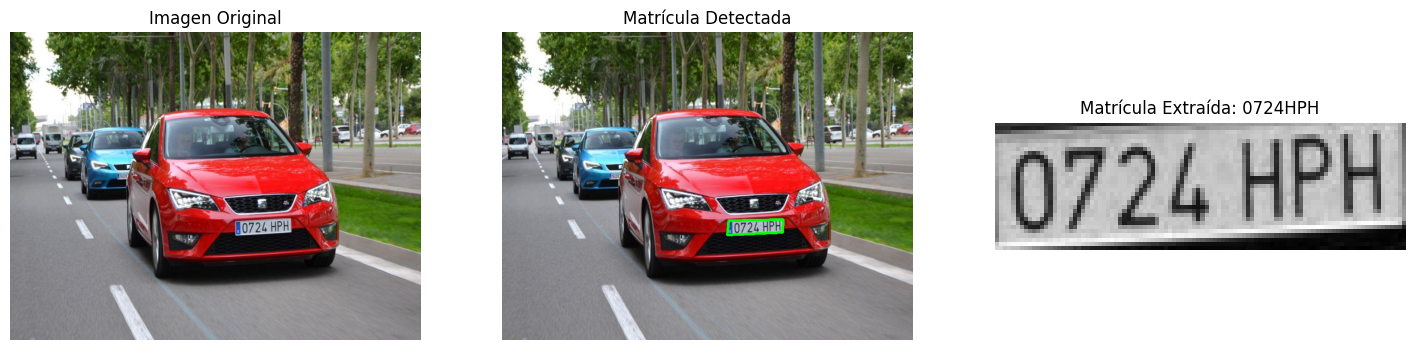

'0724HPH'

In [34]:
# Cargar imagen
def extract_plate(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (800, 600))

    # Convertir a escala de grises y detectar bordes con Canny
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.bilateralFilter(gray, 11, 17, 17)
    edged = cv2.Canny(blurred, 30, 200)

    # Encontrar contornos
    contours, _ = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    plate_contour = None

    # Buscar un contorno con 4 lados (posible matrícula)
    for c in contours:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            plate_contour = approx
            break

    if plate_contour is None:
        print("No se detectó la matrícula.")
        return None, ""

    # Dibujar el contorno detectado
    img_with_contour = img.copy()
    cv2.drawContours(img_with_contour, [plate_contour], -1, (0, 255, 0), 3)

    # Crear máscara y recortar la matrícula
    mask = np.zeros(gray.shape, np.uint8)
    cv2.drawContours(mask, [plate_contour], 0, 255, -1)

    (x, y) = np.where(mask == 255)
    (topx, topy) = (np.min(x), np.min(y))
    (bottomx, bottomy) = (np.max(x), np.max(y))

    # Ajustar el recorte lateral (reducido para no perder caracteres)
    offset = 10  # Reducimos el corte lateral
    cropped_plate = gray[topx:bottomx + 1, topy + offset:bottomy + 1]

    # Extraer el texto con Tesseract
    plate_text = pytesseract.image_to_string(cropped_plate, config='--psm 8 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')

    # Mostrar resultados
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Imagen Original")
    axs[0].axis("off")

    axs[1].imshow(cv2.cvtColor(img_with_contour, cv2.COLOR_BGR2RGB))
    axs[1].set_title("Matrícula Detectada")
    axs[1].axis("off")

    axs[2].imshow(cropped_plate, cmap='gray')
    axs[2].set_title(f"Matrícula Extraída: {plate_text.strip()}")
    axs[2].axis("off")

    plt.show()

    return plate_text.strip()


# Ejecutar la función con tu imagen
image_path = '/content/matricula.jpg'
extract_plate(image_path)
